In [293]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

file_path = "./학습데이터.csv"

In [294]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else 'cpu')
print(f'다음 기기로 학습 : {device}')

다음 기기로 학습 : cuda


In [295]:
# 1. 데이터 로드
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

In [296]:
# 2. 시간 데이터 처리
def process_time_data(df):
    # event_time을 datetime 형식으로 변환
    df['event_time'] = pd.to_datetime(df['event_time'])
    
    # 날짜 정보(연, 월, 일) 추출
    df['year'] = df['event_time'].dt.year
    df['month'] = df['event_time'].dt.month
    df['day'] = df['event_time'].dt.day

    # epc_code별 event_time 차이 계산 (초 단위)
    df['time_diff'] = df.groupby('epc_code')['event_time'].diff().dt.total_seconds().fillna(0)
    
    # time_diff 값을 로그 변환하여 스케일 조정
    df['time_diff'] = np.log1p(df['time_diff'])
    
    # time_diff의 다양한 단위 변환 추가
    df['time_diff_minutes'] = df['time_diff'] / 60
    df['time_diff_hours'] = df['time_diff'] / 3600
    df['time_diff_days'] = df['time_diff'] / 86400

    # 시간(hour)의 주기적 특성 인코딩
    df['hour'] = df['event_time'].dt.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # 월(month)의 주기적 특성 인코딩
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # 일(day)의 주기적 특성 인코딩
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    
    # 불필요한 원본 값 삭제
    df = df.drop(columns=['event_time', 'year', 'month', 'day', 'hour'], errors='ignore')
    return df

In [297]:
# 3. Label Encoding
def encode_categorical_data(df):
    # hub_type, event_type 라벨 인코딩
    le_hub = LabelEncoder()
    le_event = LabelEncoder()
    df['hub_type_encoded'] = le_hub.fit_transform(df['hub_type'])
    df['event_type_encoded'] = le_event.fit_transform(df['event_type'])

    # 허브 및 이벤트의 이전 상태 추가 (순서 학습 강화)
    df['hub_type_shifted'] = df.groupby('epc_code')['hub_type_encoded'].shift(1).fillna(-1)
    df['event_type_shifted'] = df.groupby('epc_code')['event_type_encoded'].shift(1).fillna(-1)

    # 허브 이동 횟수 추가 (허브 변경 감지)
    df['hub_transition'] = (df['hub_type_encoded'] != df['hub_type_encoded'].shift(1)).astype(int)
    
    # 원본 hub_type, event_type, product_serial, product_name  삭제 (인코딩 후 불필요)
    df = df.drop(columns=['hub_type', 'event_type'], errors='ignore')
    df = df.drop(columns=['product_serial', 'product_name'])
    
    return df

In [298]:
# 4. 시계열 데이터 구성
def create_sequences(df, seq_length):
    sequences = []
    for _, group in df.groupby('epc_code'):
        group_data = group[["time_diff_minutes", "hub_transition", "event_type_shifted", "hub_type_encoded", "event_type_encoded", "hour_sin", "month_sin"]].values
        for i in range(len(group_data) - seq_length + 1):
            sequences.append(group_data[i:i + seq_length])
    return np.array(sequences)


In [299]:
# 데이터 로드
df = load_data(file_path)

# 시간 데이터 처리
df = process_time_data(df)

# 카테고리형 데이터 인코딩
df = encode_categorical_data(df)

# 변환된 데이터 확인
display(df.head(10))

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,epc_code,label,time_diff,time_diff_minutes,time_diff_hours,time_diff_days,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,hub_type_encoded,event_type_encoded,hub_type_shifted,event_type_shifted,hub_transition
0,001.8805843.584374.000000001,0,0.000000,0.000000,0.000000,0.000000,-9.659258e-01,-2.588190e-01,0.500000,8.660254e-01,-0.897805,-0.440394,5,3,-1.0,-1.0,1
1,001.8805843.584374.000000001,0,7.139660,0.118994,0.001983,0.000083,-1.000000e+00,-1.836970e-16,0.500000,8.660254e-01,-0.897805,-0.440394,5,2,5.0,3.0,0
2,001.8805843.584374.000000001,0,7.783641,0.129727,0.002162,0.000090,-1.000000e+00,-1.836970e-16,0.500000,8.660254e-01,-0.897805,-0.440394,5,0,5.0,2.0,0
3,001.8805843.584374.000000001,0,12.627414,0.210457,0.003508,0.000146,9.659258e-01,-2.588190e-01,0.500000,8.660254e-01,-0.937752,0.347305,5,1,5.0,0.0,0
4,001.8805843.584374.000000001,0,9.372544,0.156209,0.002603,0.000108,5.000000e-01,-8.660254e-01,0.500000,8.660254e-01,-0.937752,0.347305,0,4,5.0,1.0,1
5,001.8805843.584374.000000001,0,14.942594,0.249043,0.004151,0.000173,8.660254e-01,5.000000e-01,1.000000,6.123234e-17,0.394356,0.918958,0,7,0.0,4.0,0
6,001.8805843.584374.000000001,0,10.280587,0.171343,0.002856,0.000119,1.224647e-16,-1.000000e+00,1.000000,6.123234e-17,0.394356,0.918958,0,6,0.0,7.0,0
7,001.8805843.584374.000000001,0,14.610176,0.243503,0.004058,0.000169,7.071068e-01,7.071068e-01,1.000000,6.123234e-17,-0.571268,0.820763,0,9,0.0,6.0,0
8,001.8805843.584374.000000001,0,9.643485,0.160725,0.002679,0.000112,9.659258e-01,-2.588190e-01,1.000000,6.123234e-17,-0.571268,0.820763,0,5,0.0,9.0,0
9,001.8805843.584374.000000001,0,14.376680,0.239611,0.003994,0.000166,-5.000000e-01,-8.660254e-01,0.866025,-5.000000e-01,-0.299363,-0.954139,0,8,0.0,5.0,0


In [300]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 상관관계 히트맵
# correlation_matrix = df.corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
# plt.title("Feature Correlation Matrix")
# plt.show()

In [301]:
# 5. 데이터 정규화
def normalize_data(sequences):
    sequences = sequences.astype(np.float32)
    sequences[np.isnan(sequences)] = 0  # NaN 값 처리
    sequences[np.isinf(sequences)] = 0  # Inf 값 처리

    minmax_scaler = MinMaxScaler()
    minmax_indices = [0]  # time_diff 관련 열

    standard_scaler = StandardScaler()
    standard_indices = [5, 6]  # 시간 주기적 변수

    # MinMaxScaler 적용
    sequences[:, :, minmax_indices] = minmax_scaler.fit_transform(
        sequences[:, :, minmax_indices].reshape(-1, len(minmax_indices))
    ).reshape(sequences.shape[0], sequences.shape[1], len(minmax_indices))

    # StandardScaler 적용
    sequences[:, :, standard_indices] = standard_scaler.fit_transform(
        sequences[:, :, standard_indices].reshape(-1, len(standard_indices))
    ).reshape(sequences.shape[0], sequences.shape[1], len(standard_indices))

    return sequences

In [302]:
# 6. 데이터 분할 (시퀀스 데이터 기반으로 라벨 유지)
def split_sequences(df, sequences, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    df_normal = df[df['label'] == 0].reset_index(drop=True)  # 정상 데이터
    df_anomalies = df[df['label'] == 1].reset_index(drop=True)  # 이상 데이터

    num_train = int(len(df_normal) * train_ratio)
    num_val = int(len(df_normal) * val_ratio)

    # 시퀀스 데이터에서 정상 라벨에 해당하는 부분 추출
    normal_sequences = sequences[:len(df_normal)]
    anomaly_sequences = sequences[len(df_normal):]

    # 훈련 데이터: 정상 데이터만 사용
    train_data = normal_sequences[:num_train]

    # 검증 데이터: 정상 데이터 일부 + 이상 데이터 일부 포함
    val_data = np.concatenate([normal_sequences[num_train:num_train + num_val], anomaly_sequences[:num_val]], axis=0)

    # 테스트 데이터: 나머지 정상 데이터 + 나머지 이상 데이터 포함
    test_data = np.concatenate([normal_sequences[num_train + num_val:], anomaly_sequences[num_val:]], axis=0)

    return train_data, val_data, test_data


In [303]:
# 7. LSTM Autoencoder 모델 생성 및 학습
def build_lstm_autoencoder(seq_length, feature_dim):
    model = models.Sequential([
        layers.LSTM(256, activation='relu', return_sequences=True, input_shape=(seq_length, feature_dim)),
        layers.Dropout(0.2),
        layers.LSTM(128, activation='relu', return_sequences=True),
        layers.LSTM(16, activation='relu', return_sequences=False),
        layers.RepeatVector(seq_length),
        layers.LSTM(16, activation='relu', return_sequences=True),
        layers.LSTM(128, activation='relu', return_sequences=True),
        layers.LSTM(256, activation='relu', return_sequences=True),
        layers.TimeDistributed(layers.Dense(feature_dim))
    ])
    
    # 학습률 조정
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# 모델 학습
def train_autoencoder(model, X_train, X_val, epochs=10, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, X_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(X_val, X_val), 
                        callbacks=[early_stopping])
    return history

# LSTM Autoencoder의 재구성 오류 계산 함수
def compute_reconstruction_error(model, X_test):
    X_pred = model.predict(X_test)
    reconstruction_errors = np.mean(np.abs(X_test - X_pred), axis=(1, 2))
    return reconstruction_errors

# 이상 탐지 수행
def detect_anomalies(model, X_test, method="zscore", percentile=95):
    reconstruction_errors = compute_reconstruction_error(model, X_test)
    
    # 2. 선택된 방법에 따라 임계값 계산
    if method == "percentile":
        threshold = np.percentile(reconstruction_errors, percentile)
    
    elif method == "zscore":
        mean = np.mean(reconstruction_errors)
        std = np.std(reconstruction_errors)
        threshold = mean + 3 * std  # 평균 + 3 * 표준편차
    
    elif method == "iqr":
        Q1 = np.percentile(reconstruction_errors, 25)
        Q3 = np.percentile(reconstruction_errors, 75)
        IQR = Q3 - Q1
        threshold = Q3 + 1.5 * IQR  # 이상 탐지 기준
    
    else:
        raise ValueError("method는 'percentile', 'zscore', 'iqr' 중 하나여야 합니다.")
    
    # 이상 데이터 감지
    anomalies = reconstruction_errors > threshold
    return anomalies, threshold

In [304]:
# 8. 파이프라인 실행
def preprocess_pipeline(file_path, seq_length=10):
    # 1. 데이터 로드 및 전처리
    df = load_data(file_path)
    df = process_time_data(df) 
    df = encode_categorical_data(df)

    # 2. 시계열 데이터 변환 및 정규화
    sequences = create_sequences(df, seq_length)
    sequences = normalize_data(sequences)

    # 3. 데이터 분할 (정상/이상 라벨 유지)
    train_sequences, val_sequences, test_sequences = split_sequences(df, sequences)

    # 4. 모델 생성 및 학습
    feature_dim = sequences.shape[2]
    model = build_lstm_autoencoder(seq_length, feature_dim)
    train_autoencoder(model, train_sequences, val_sequences)

    return model, train_sequences, val_sequences, test_sequences


In [ ]:
# 9. 모델 학습 실행
file_path = "./학습데이터.csv"  # 파일 경로 지정
seq_length = 10  # LSTM 시퀀스 길이 설정

# 파이프라인 실행
model, train_data, val_data, test_data = preprocess_pipeline(file_path, seq_length)

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch 1/10


c:\Users\user\anaconda3\envs\torch_book\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2776/2776 ━━━━━━━━━━━━━━━━━━━━ 78s 26ms/step - loss: 1.5216 - val_loss: 0.1407
Epoch 2/10
2231/2776 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.1729

In [ ]:
# 10. 이상 탐지 실행
anomalies, threshold = detect_anomalies(model, test_data)

# 이상 탐지된 데이터 확인
print("이상 탐지된 샘플 수:", np.sum(anomalies))
print("사용된 임계값 (Threshold):", threshold)

347/347 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
이상 탐지된 샘플 수: 66
사용된 임계값 (Threshold): 0.1931907


In [207]:
# 11. 성능 평가 함수
def evaluate_performance(model, X_test, labels, threshold):
    # 1. 재구성 오류 계산
    reconstruction_errors = compute_reconstruction_error(model, X_test)

    # 2. 임계값 기반 이상치 감지
    anomalies = reconstruction_errors > threshold

    # 3. ROC-AUC 계산
    fpr, tpr, _ = roc_curve(labels, reconstruction_errors)
    roc_auc = auc(fpr, tpr)

    # 4. Precision, Recall, F1-Score 계산
    precision, recall, f1, _ = precision_recall_fscore_support(labels, anomalies, average='binary')

    # 5. 혼동 행렬 계산
    def plot_confusion_matrix(cm, labels):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    # 혼동 행렬 계산 및 시각화
    cm = confusion_matrix(labels, anomalies)
    plot_confusion_matrix(cm, labels=['Normal', 'Anomaly'])

    # 결과 출력
    print("ROC-AUC 점수:", roc_auc)
    print("Precision (정밀도):", precision)
    print("Recall (재현율):", recall)
    print("F1-Score:", f1)
    print("혼동 행렬:\n", cm)

    # 시각화
    # (1) ROC 곡선
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'r--')  # 대각선 기준선
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    
    # 한글 폰트 경로 설정
    plt.rcParams['font.family'] ='Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] =False

    # (2) 재구성 오류 분포
    plt.figure(figsize=(10, 6))
    sns.histplot(reconstruction_errors[labels == 0], bins=50, color='blue', label='정상 데이터', kde=True)
    sns.histplot(reconstruction_errors[labels == 1], bins=50, color='red', label='이상 데이터', kde=True)
    plt.axvline(x=threshold, color='black', linestyle='--', label='임계값')
    plt.xlabel("재구성 오류 (Reconstruction Error)")
    plt.ylabel("빈도수")
    plt.title("정상 vs 이상 데이터의 재구성 오류 분포")
    plt.legend()
    plt.grid()
    plt.show()
    
    def plot_training_history(history):
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title("Training and Validation Loss Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        plot_training_history(history)

347/347 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


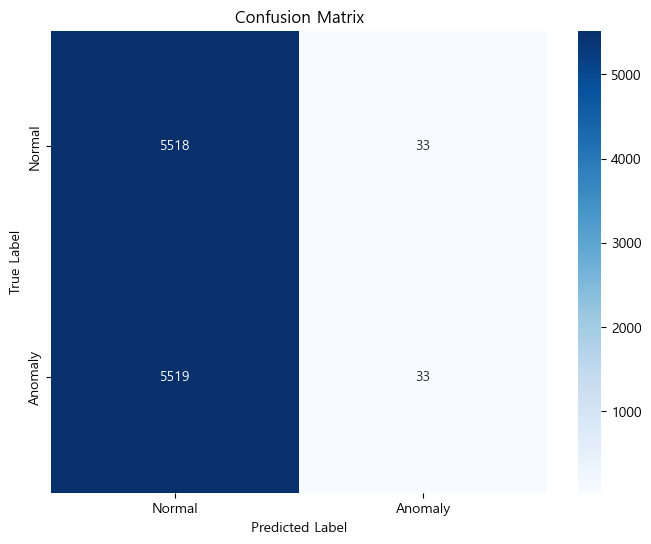

ROC-AUC 점수: 0.5040564224479636
Precision (정밀도): 0.5
Recall (재현율): 0.005943804034582133
F1-Score: 0.011747953008187968
혼동 행렬:
 [[5518   33]
 [5519   33]]


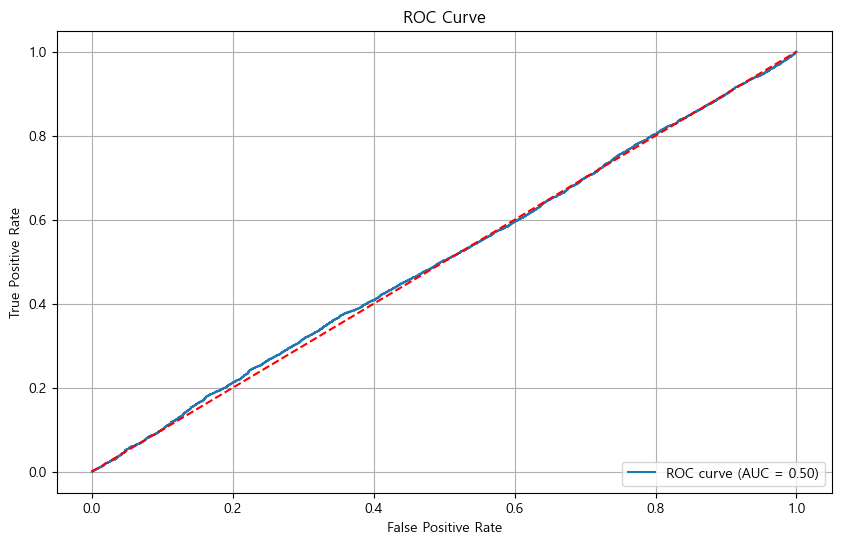

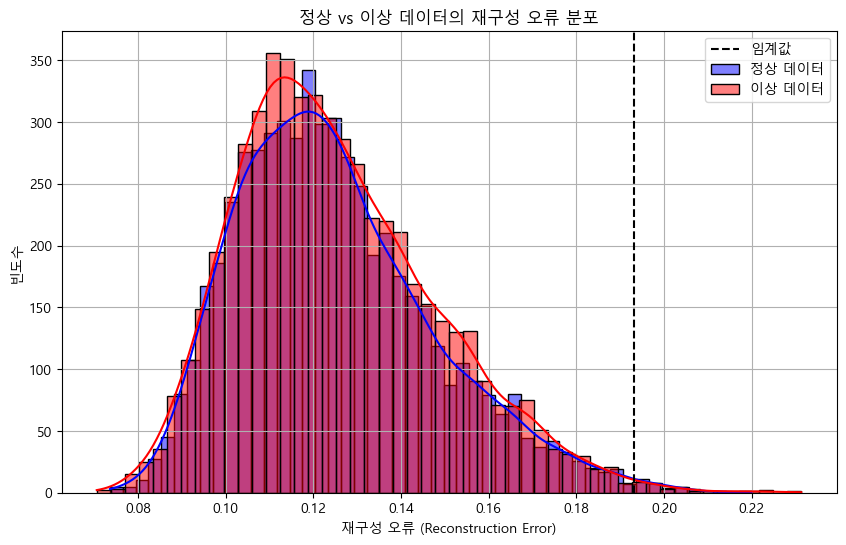

In [ ]:
# 12. 성능 평가 실행
# 테스트 데이터 라벨 추가 (임의로 정상: 0, 이상: 1 라벨 사용)
labels = np.array([0 if i < len(test_data) // 2 else 1 for i in range(len(test_data))])

# 성능 평가 실행
evaluate_performance(model, test_data, labels, threshold)

In [209]:
# 학습 완료 후 모델 저장
model.save("lstm_autoencoder_model.h5")